# Project 1: Uncovering Insights in Supply Chain Management Case Studies: A LDA Topic Modelling Approach

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud
#!pip install --upgrade pymupdf
import fitz
import re
import pickle

#spacy resource
#!pip install spacy
#!python -m spacy download en_core_web_sm 
import spacy
import en_core_web_sm

#LDA topic modelling using Gensim tool
#!pip install gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel


#Hyperparaeters tuning
from sklearn.model_selection import ParameterGrid

#!pip install toml
#Visualize (pyLDAvis)
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

## Extract Text From PDF

In [2]:
def extract_text(file_path):
    # Open the PDF file
    pdf_document = fitz.open(file_path)

    # Initialize an empty string to store the text
    text = ""

    # Loop through each page and extract text
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text += page.get_text()

    # Close the PDF document
    pdf_document.close()

    return text

def text_from_introduction(text):
    # Define a regular expression pattern to identify the introduction section
    pattern = r"Introduction|INTRODUCTION|Motivation|MOTIVATION|Background"  # Add introduction word

    # Use regular expression to find the start of the introduction section
    intro_start_match = re.search(pattern, text)

    if intro_start_match:
        intro_start_index = intro_start_match.start()
        intro_section = text[intro_start_index:]
    else:
        intro_section = text  # If no introduction section found, keep the original text

    return intro_section.strip()  # Remove leading and trailing whitespace

def remove_references(text):
    # Define a regular expression pattern to identify the references section
    pattern = r"References|Acknowledgements|REFERENCES|ACKNOWLEDGEMENTS"  # Remove section words

    # Use regular expression to split the text based on the references section
    sections = re.split(pattern, text)

    # Take only the part before the references section
    if len(sections) > 0:
        cleaned_article = sections[0]
    else:
        cleaned_article = text  # If no references section found, keep the original text

    return cleaned_article.strip()  # Remove leading and trailing whitespace

def extract_pdf_text(folder_path):
    data = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.pdf'):
                year = os.path.basename(root)
                article_name = os.path.splitext(file)[0]
                file_path = os.path.join(root, file)
                text = extract_text(file_path)
                start_article = text_from_introduction(text)
                cleaned_article = remove_references(start_article)
                data.append({'Year': year, 'Article Name': article_name, 'Text': cleaned_article})
    return pd.DataFrame(data)

folder_path = 'Supply Chain Case Study Scopus'
articles_df = extract_pdf_text(folder_path)

# Notify after done
print("Done extraction!")


Done extraction!


In [4]:
articles_df.head()

,Year,Article Name,Text
0,1998,Supply chain management A case study of issues...,Introduction \nThe objective of this case is t...
1,2000,Changing governance of supply chains in the bu...,"Introduction\nIn the building industry, design..."
2,2000,Upstream volatility in the supply chain The ma...,Motivation\nCyclicality is a well-known and ac...
3,2003,Amplification in service supply chains An expl...,Introduction\nUpstream ampliﬁcation of demand ...
4,2004,Evaluating the integration of supply chain inf...,Introduction\nMany deﬁnitions exist in the nor...


In [5]:
articles_df.isnull().sum()

Year            0
Article Name    0
Text            0
dtype: int64

## Data Preprocessing

### Data Cleaning
- Removing special pattern terms
- Tokenization
- Removing punctuation and Stopwords
- Remain the words that is alphabet 
- Remain the words which POS_tag in ["NOUN", "ADJ", "VERB", "ADV"]
- Remain the words which more than 4 characters
- Lemmatization

In [6]:
# Load Spacy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
stopword_list= nlp.Defaults.stop_words

# Define words to add into stopword_list
words_to_add = {"introduction", "objective", "motivation", "literature review", "methodology", "discussion", "conclusion", "figure", "table","sfsc"}

# Add all words to the stop word list
stopword_list.update(words_to_add)


In [7]:
# Function to preprocess text
def preprocess_text(text):
    
    # Check if pattern exists in the text
    if re.search(r'\([A-Z].*?,\s\d{4}\)', text):
        text = re.sub(r'\([A-Z].*?,\s\d{4}\)', '', text)
        
    # Convert text to lowercase
    text = text.lower()

    # Check for hyphen followed by newline
    if re.search(r'-\s*\n', text):
        # Combine hyphenated words if followed by newline
        text = re.sub(r'(\w+)-\s*\n(\w+)', r'\1\2', text)
    
    # Tokenize the text using spaCy
    doc = nlp(text)
    
    # Removing stopwords and punctuation, remain alphatical characters with only POS_tag 
    # Then lemmatizing and remain the words more than 4 characters.
    filtered_tokens = [token.lemma_ for token in doc if 
                       not token.like_url and
                       not token.like_email and
                       token.is_alpha and
                       not token.is_punct and
                       token.text not in stopword_list and 
                       token.pos_ in ["NOUN", "ADJ", "VERB", "ADV"] and 
                       len(token.lemma_) > 3]
     
    # Join the filtered tokens back into a string
    filtered_text = " ".join(filtered_tokens)

    return filtered_text, filtered_tokens



In [8]:
# Apply preprocessing function to text and store preprocessed text and tokenized words in new columns
articles_df['Preprocessed Text'], articles_df['Tokens'] = zip(*articles_df['Text'].apply(preprocess_text))

In [9]:
# Function to count words using spaCy
def count_words_spacy(text):
    doc = nlp(text)
    return len([token for token in doc])


total_words = articles_df['Text'].apply(count_words_spacy).sum()

print("Total number of words before preprocessing:", total_words)

Total number of words before preprocessing: 5297731


In [10]:
# Function to count words using spaCy
def count_words_spacy(text):
    doc = nlp(text)
    return len([token for token in doc if token.is_alpha])


total_alpha_words = articles_df['Text'].apply(count_words_spacy).sum()

print("Total number of alphabetic words before preprocessing:", total_alpha_words)

Total number of alphabetic words before preprocessing: 3508721


In [11]:
# Calculate the total number of preprocessed words
total_preprocessed_words = articles_df['Tokens'].apply(len).sum()

print("Total number of words after preprocessing:", total_preprocessed_words)

Total number of words after preprocessing: 1757092


In [12]:
articles_df.head()

,Year,Article Name,Text,Preprocessed Text,Tokens
0,1998,Supply chain management A case study of issues...,Introduction \nThe objective of this case is t...,case introduce concept supply chain management...,"[case, introduce, concept, supply, chain, mana..."
1,2000,Changing governance of supply chains in the bu...,"Introduction\nIn the building industry, design...",building industry designing construct supply p...,"[building, industry, designing, construct, sup..."
2,2000,Upstream volatility in the supply chain The ma...,Motivation\nCyclicality is a well-known and ac...,cyclicality know accept fact life market drive...,"[cyclicality, know, accept, fact, life, market..."
3,2003,Amplification in service supply chains An expl...,Introduction\nUpstream ampliﬁcation of demand ...,upstream ampliﬁcation demand workload notoriou...,"[upstream, ampliﬁcation, demand, workload, not..."
4,2004,Evaluating the integration of supply chain inf...,Introduction\nMany deﬁnitions exist in the nor...,deﬁnition exist normative literature supply ch...,"[deﬁnition, exist, normative, literature, supp..."


## Feature Extraction
- Using Doc2Bow from Gensim tools to transform tokenized cleaned text to Document-term Matrix

In [13]:
# Create a dictionary representation of the documents
dictionary = Dictionary(articles_df['Tokens'])

# Apply filtering to a new dictionary
dictionary_after = Dictionary(articles_df['Tokens'])
# Filter out words that occur less than 0.5% of the documents, or more than 90% of the documents.
dictionary_after.filter_extremes(no_below=3, no_above=0.90)

# Bag-of-words representation of the documents.
corpus_after = [dictionary_after.doc2bow(tokens) for tokens in articles_df['Tokens']]

In [32]:
# before prunning
token2id_before = set(dictionary.token2id.keys())
# after prunning
token2id_after = set(dictionary_after.token2id.keys())


# size of the dictionary before prunning
size_before = len(dictionary)
# of the dictionary after prunning
size_after = len(dictionary_after)

print("Number of words before prunning:", size_before)
print("Number of words after prunning:", size_after)

Number of words before prunning: 31026
Number of words after prunning: 9365


## Pickle the files

In [20]:
# Pickle the articles_df
articles_df.to_pickle("pickle/cleaned_article.pkl")

# Pickle the corpus
with open('pickle/corpus_after.pickle', 'wb') as f:
    pickle.dump(corpus_after, f)

# Pickle the dictionary
with open('pickle/dictionary_after.pickle', 'wb') as f:
    pickle.dump(dictionary_after, f)

## LDA Modelling
- Using LDA topic modelling from Gensim tools

In [14]:
# Train LDA model
num_topics = 6
lda_model = LdaModel(corpus_after, id2word=dictionary_after, num_topics=num_topics, update_every=1, chunksize=50, passes=10, alpha ='auto', random_state=123)

# Print topics and their top words
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx}')
    print(f'Top Words: {topic}')
    print()

Topic: 0
Top Words: 0.020*"company" + 0.013*"practice" + 0.012*"sustainability" + 0.012*"supplier" + 0.011*"industry" + 0.008*"business" + 0.007*"sustainable" + 0.007*"relationship" + 0.006*"development" + 0.006*"performance"

Topic: 1
Top Words: 0.031*"model" + 0.016*"demand" + 0.013*"transportation" + 0.012*"capacity" + 0.012*"center" + 0.012*"scenario" + 0.012*"period" + 0.011*"location" + 0.011*"consider" + 0.011*"parameter"

Topic: 2
Top Words: 0.020*"risk" + 0.010*"supplier" + 0.009*"customer" + 0.009*"order" + 0.009*"model" + 0.009*"service" + 0.009*"pandemic" + 0.008*"demand" + 0.008*"company" + 0.008*"performance"

Topic: 3
Top Words: 0.040*"food" + 0.012*"farmer" + 0.010*"market" + 0.010*"price" + 0.009*"area" + 0.009*"consumer" + 0.008*"producer" + 0.008*"agricultural" + 0.007*"local" + 0.006*"online"

Topic: 4
Top Words: 0.019*"emission" + 0.019*"hydrogen" + 0.018*"energy" + 0.015*"waste" + 0.011*"environmental" + 0.009*"pipeline" + 0.009*"transport" + 0.009*"carbon" + 0.00

## Model Evaluation
- Evaluation metrics using coherence score

In [15]:
# Evaluate model coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=articles_df['Tokens'], dictionary=dictionary_after, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')


Coherence Score: 0.5120643284833679


## Visualization
- Using pyLDAvis for interpreting the result

In [16]:
# Prepare data for pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus_after, dictionary_after)

# Visualize the topics
pyLDAvis.display(vis_data)

## Hyperparameter Tuning

### Number of Topics Tuning

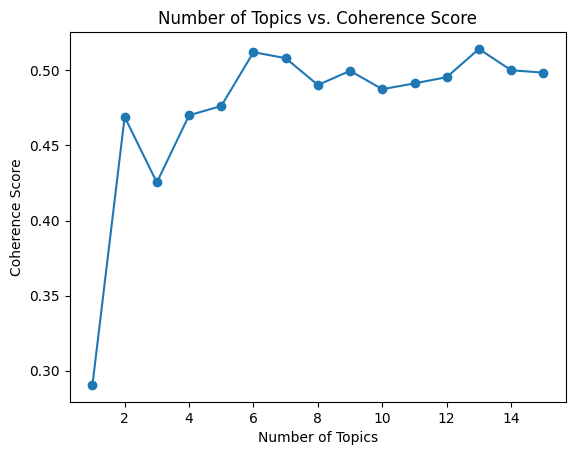

In [21]:
# Lists to store the number of topics and corresponding coherence values
num_topics_list = []
coherence_values = []

# Grid search over number of topics
for num_topics in range(1, 16):  # Range from 1 to 15
    lda_model = LdaModel(corpus=corpus_after, id2word=dictionary_after, num_topics=num_topics,update_every=1, chunksize=50, passes=10,random_state=123)
    coherence_model = CoherenceModel(model=lda_model, texts=articles_df['Tokens'], dictionary=dictionary_after, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    num_topics_list.append(num_topics)
    coherence_values.append(coherence_score)

# Plot
plt.plot(num_topics_list, coherence_values, marker='o')
plt.title('Number of Topics vs. Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(False)
plt.show()

### Alpha and Beta Tuning

In [25]:
# Parameter grid alpha and beta values
param_grid = {
    'alpha': ['auto', 'symmetric', 'asymmetric'],
    'beta': ['auto', 'symmetric']
}

# Lists to store the results
results = []

# Grid search
for params in ParameterGrid(param_grid):
    alpha = params['alpha']
    beta = params['beta']
    
    lda_model = LdaModel(
        corpus=corpus_after,
        id2word=dictionary_after,
        num_topics=6, 
        update_every=1,
        chunksize=50,
        passes=10,
        alpha=alpha,
        eta=beta,
        random_state=123
    )
    
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=articles_df['Tokens'],
        dictionary=dictionary_after,
        coherence='c_v'
    )
    
    coherence_score = coherence_model.get_coherence()
    results.append([alpha, beta, coherence_score])

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Alpha', 'Beta', 'Coherence Score'])
sorted_df = df.sort_values(by='Coherence Score', ascending=False)
print(sorted_df)


        Alpha       Beta  Coherence Score
0        auto       auto         0.512072
1        auto  symmetric         0.512072
2   symmetric       auto         0.512072
3   symmetric  symmetric         0.512072
4  asymmetric       auto         0.512072
5  asymmetric  symmetric         0.512072


### Chunksize and passes Tuning

In [23]:
# Parameter grid for chunksize and passes
# Parameter grid alpha and beta values
param_grid = {
    'chunk_size': [50, 100, 300, 569],
    'passes': [5, 10, 15]
}

# Lists to store the results
results = []

# Grid search
for params in ParameterGrid(param_grid):
    chunk_size = params['chunk_size']
    passes = params['passes']
    
    lda_model = LdaModel(
        corpus=corpus_after,
        id2word=dictionary_after,
        num_topics=6, 
        update_every=1,
        chunksize=chunk_size,
        passes=passes,
        alpha='auto',
        eta='auto',
        random_state=123
    )
    
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=articles_df['Tokens'],
        dictionary=dictionary_after,
        coherence='c_v'
    )
    
    coherence_score = coherence_model.get_coherence()
    results.append([chunk_size, passes, coherence_score])

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Chunk Size', 'Passes', 'Coherence Score'])
sorted_df = df.sort_values(by='Coherence Score', ascending=False)
print(sorted_df)


    Chunk Size  Passes  Coherence Score
1           50      10         0.512072
0           50       5         0.511823
2           50      15         0.510365
8          300      15         0.495726
3          100       5         0.494422
5          100      15         0.491148
7          300      10         0.487268
4          100      10         0.486015
6          300       5         0.473969
11         569      15         0.471756
10         569      10         0.464503
9          569       5         0.399250


## Update best hyperparameters

In [17]:
# Train LDA model
num_topics = 6
chunksize = 50
passes = 10
alpha = 'auto'
beta = 'auto'


lda_model = LdaModel(corpus_after, id2word=dictionary_after, num_topics=num_topics, update_every=1, chunksize=chunksize, passes=passes, alpha =alpha, eta = beta, random_state=123)

# Print topics and their top words
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx}')
    print(f'Top Words: {topic}')
    print()

Topic: 0
Top Words: 0.020*"company" + 0.013*"practice" + 0.012*"sustainability" + 0.012*"supplier" + 0.011*"industry" + 0.008*"business" + 0.007*"sustainable" + 0.007*"relationship" + 0.006*"development" + 0.006*"performance"

Topic: 1
Top Words: 0.031*"model" + 0.016*"demand" + 0.013*"transportation" + 0.012*"capacity" + 0.012*"center" + 0.012*"scenario" + 0.012*"period" + 0.011*"location" + 0.011*"consider" + 0.011*"parameter"

Topic: 2
Top Words: 0.020*"risk" + 0.010*"supplier" + 0.009*"customer" + 0.009*"order" + 0.009*"model" + 0.009*"service" + 0.009*"pandemic" + 0.008*"demand" + 0.008*"company" + 0.008*"performance"

Topic: 3
Top Words: 0.040*"food" + 0.012*"farmer" + 0.010*"market" + 0.010*"price" + 0.009*"area" + 0.009*"consumer" + 0.008*"producer" + 0.008*"agricultural" + 0.007*"local" + 0.006*"online"

Topic: 4
Top Words: 0.019*"emission" + 0.019*"hydrogen" + 0.018*"energy" + 0.015*"waste" + 0.011*"environmental" + 0.009*"pipeline" + 0.009*"transport" + 0.009*"carbon" + 0.00

In [18]:
coherence_model = CoherenceModel(model=lda_model, texts=articles_df['Tokens'], dictionary=dictionary_after, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.5120643284833679


In [19]:
coherence_per_topic = coherence_model.get_coherence_per_topic()
for i, score in enumerate(coherence_per_topic):
    print(f"Topic {i}: Coherence Score = {score}")

Topic 0: Coherence Score = 0.4981858547957083
Topic 1: Coherence Score = 0.5376817439978838
Topic 2: Coherence Score = 0.34769337047696025
Topic 3: Coherence Score = 0.5616030210743043
Topic 4: Coherence Score = 0.611856531528351
Topic 5: Coherence Score = 0.5153654490269995


In [6]:
# Parameters as a dictionary
lda_params = {
    'Number of Topics': [num_topics],
    'Alpha': [alpha],
    'Beta': [beta],
    'Chunksize': [chunksize],
    'Passes': [passes]
}

# Convert dictionary to DataFrame
df = pd.DataFrame(lda_params)

# Specify the CSV file path
csv_file_path = 'lda_params.csv'

# Save DataFrame to CSV
df.to_csv(csv_file_path, index=False)

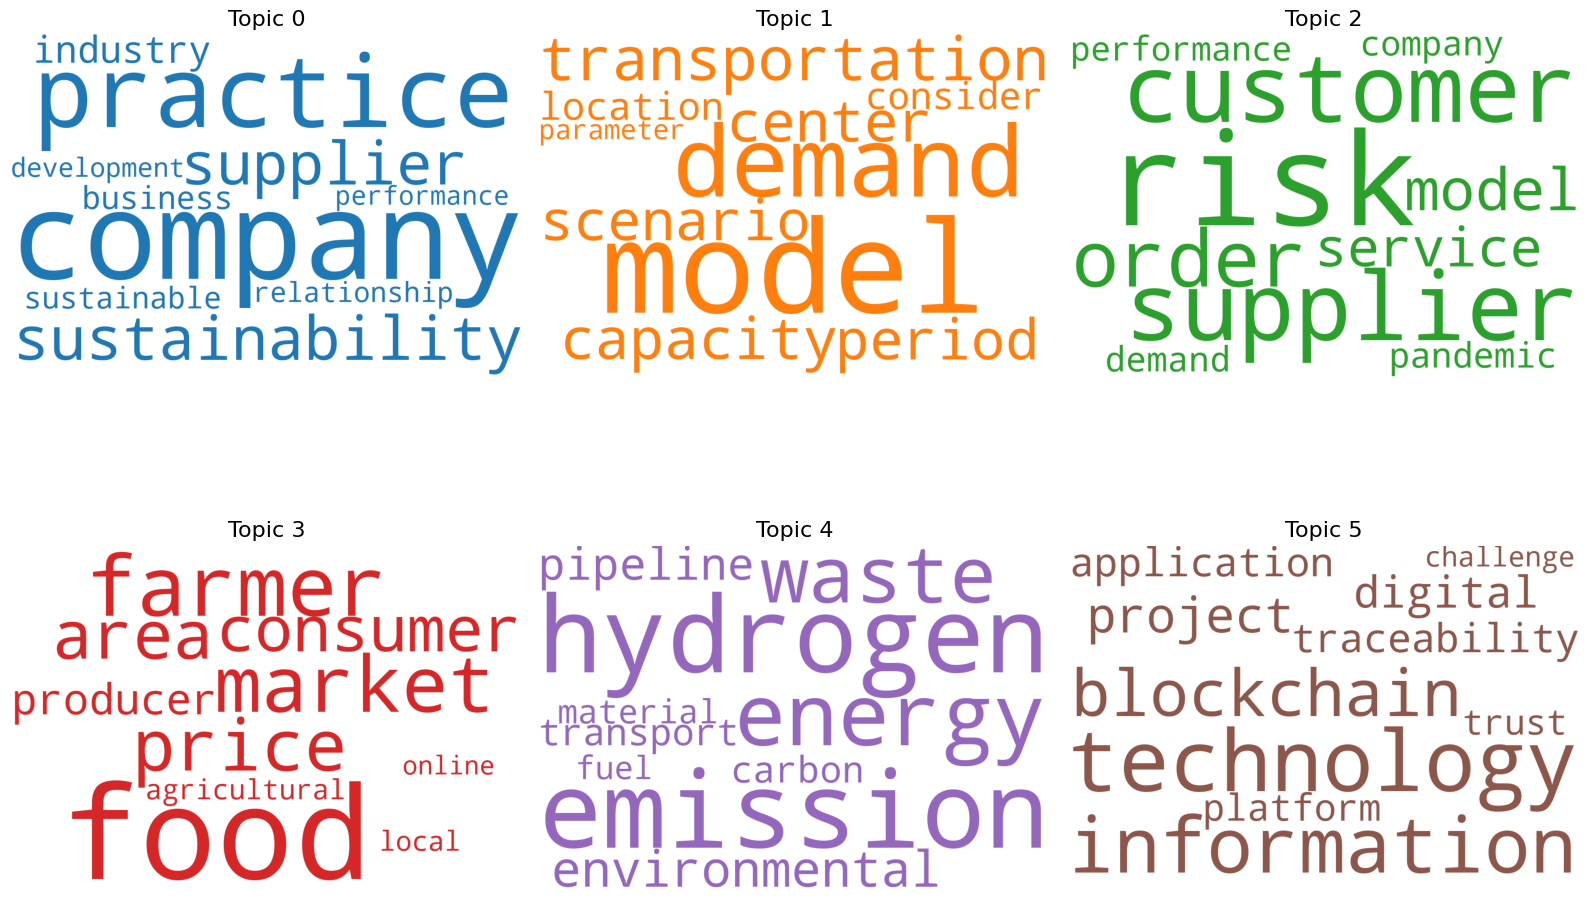

In [20]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(background_color='white',
                  width=1200,
                  height=800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(16,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('WordCloud_Topic.png')
plt.show()

In [26]:
vis_data = gensimvis.prepare(lda_model, corpus_after, dictionary_after)

# Save the model and visualize in html format
pyLDAvis.save_html(vis_data, 'lda.html')

## Assign Topic Number

In [22]:
# Get the topic distribution for each document
topic_distribution = lda_model.get_document_topics(corpus_after)

# Extract dominant topics and top words
topic_numbers = []
top_words = []
topic_probabilities = []
for doc_topics in topic_distribution:
    dominant_topic, dominant_topic_prob = max(doc_topics, key=lambda x: x[1])
    topic_words = lda_model.show_topic(dominant_topic)
    top_words.append(', '.join([word for word, _ in topic_words]))
    topic_numbers.append(dominant_topic)
    topic_probabilities.append(dominant_topic_prob)

# Add topic number, top words, and topic probabilities columns to the articles DataFrame
articles_df['Topic_Number'] = topic_numbers
articles_df['Topic_Probability'] = topic_probabilities
articles_df.to_pickle("pickle/cleaned_article.pkl")

In [23]:
clustering_df = articles_df[['Year', 'Article Name', 'Topic_Number', 'Topic_Probability']]
clustering_df[:10]

,Year,Article Name,Topic_Number,Topic_Probability
0,1998,Supply chain management A case study of issues...,0,0.537706
1,2000,Changing governance of supply chains in the bu...,5,0.498440
2,2000,Upstream volatility in the supply chain The ma...,2,0.726616
3,2003,Amplification in service supply chains An expl...,2,0.623924
4,2004,Evaluating the integration of supply chain inf...,5,0.516486
5,2005,Concurrent trajectory and vehicle optimization...,1,0.546768
6,2005,Controlling inventories in a supply chain A ca...,2,0.637123
7,2005,Relationships within the supply chain A case s...,0,0.523061
8,2006,Case-study How to implement collaborative soft...,0,0.450676
9,2006,Modularity in supply chains A multiple case st...,5,0.585138


In [25]:
# Count occurrences of each topic over years
topic_counts = clustering_df.groupby(['Year', 'Topic_Number']).size().reset_index(name='Count')

# Find the most trending topics over time
trending_topics = topic_counts.sort_values(by=['Year', 'Count'], ascending=[True, False]).groupby('Year').head(1)

print(trending_topics)

    Year  Topic_Number  Count
0   1998             0      1
1   2000             2      1
3   2003             2      1
4   2004             5      1
5   2005             0      1
8   2006             0      1
11  2007             2      2
14  2008             2      2
16  2009             0      1
19  2010             0      3
21  2011             0      4
26  2012             0      3
32  2013             2      7
36  2014             0      5
40  2015             0      9
45  2016             0      9
50  2017             0      8
58  2018             2     14
64  2019             2     23
70  2020             2     24
74  2021             0     16
82  2022             2     28
86  2023             0     23
94  2024             2      8


<Figure size 1200x600 with 0 Axes>

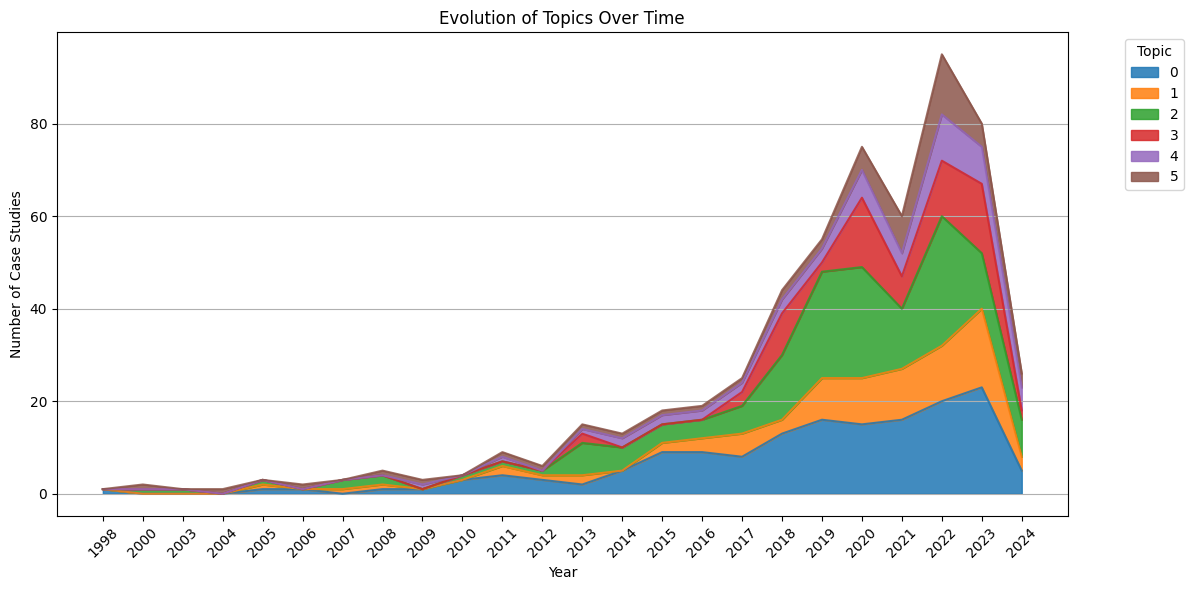

In [26]:
# Pivot the DataFrame to have topics as columns and years as index
pivot_df = topic_counts.pivot(index='Year', columns='Topic_Number', values='Count').fillna(0)

# Plotting a stacked area chart
plt.figure(figsize=(12, 6))
pivot_df.plot(kind='area', stacked=True, alpha=0.85, figsize=(12, 6))

plt.xlabel('Year')
plt.ylabel('Number of Case Studies')
plt.title('Evolution of Topics Over Time')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.xticks(range(len(pivot_df.index)), pivot_df.index, rotation=45)
plt.tight_layout()
plt.savefig('Topic_Evolution.png')

plt.show()


### Save the topics and words in csv file

In [27]:
topics_data = []

for idx, topic in lda_model.print_topics(-1):
    # Extract the top words for each topic
    top_words = [word.split("*")[1].strip().strip('"') for word in topic.split(" + ")]
    
    # Append topic and its top words to the list
    topics_data.append({
        'Topic': idx,
        'Top Words': ', '.join(top_words)
    })

# Create a DataFrame from the list of topic data
topics_df = pd.DataFrame(topics_data)

# Save the DataFrame to a CSV file
topics_df.to_csv('lda_topics.csv', index=False)

In [28]:
# Set a threshold for significant topics
threshold = 0.1 

# Initialize a list to store the results
results = []

# Iterate over each document in the corpus
for idx, bow in enumerate(corpus_after):
    # Get the topic distribution for the document
    topic_distribution = lda_model.get_document_topics(bow)
    
    # Filter significant topics
    significant_topics = {f'Topic_{topic_id}': prob for topic_id, prob in topic_distribution if prob >= threshold}
    
    # Create a dictionary with the article name and its significant topics
    article_data = {"Article Name": articles_df.iloc[idx]["Article Name"]}
    article_data.update(significant_topics)
    
    # Append the article's data to the results list
    results.append(article_data)

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('articles_significant_topics.csv', index=False)

In [ ]:
!streamlit run lda.py